In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%load_ext watermark
%watermark

2019-06-27T11:26:57-04:00

CPython 3.7.3
IPython 7.5.0

compiler   : GCC 8.3.0
system     : Linux
release    : 5.0.0-15-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


In [2]:
from pathlib import Path
from shutil import copyfile, rmtree
import json
import pdb
import pandas as pd
from ipywidgets import interact
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Constants allow for smoother editing.

In [3]:
DATA_DIR = Path('.') / 'data'
IMG_DIR = DATA_DIR / 'images'
EXP_DIR = DATA_DIR / 'expedition'
VAL_DIR = DATA_DIR / 'valid'
TRN_DIR = DATA_DIR / 'train'

RECON_CSV = EXP_DIR / '8296_label_babel.reconciled.csv'
TRN_CSV = DATA_DIR / 'train.csv'
VAL_CSV = DATA_DIR / 'valid.csv'

BOX = 'box'
CAT = 'category'
ORI = 'original'
PATH = 'path'
CLASS = 'class'
SUB_ID = 'subject_id'

LFT = 'left'
RGT = 'right'
TOP = 'top'
BOT = 'bottom'

TYPEWRITTEN = 'typewritten'
HANDWRITTEN = 'handwritten'

SEED = 23

In [4]:
SCALE = 0.25


def scale(value):
    return int(round(value * SCALE))

In [5]:
def box_as_array(box):
    box = json.loads(box)
    return [
        scale(box[LFT]),  # x0
        scale(box[TOP]),  # y0
        scale(box[RGT]),  # x1
        scale(box[BOT])]  # y1

Reshape the input (reconciled) data into a form that is easier to work with.

In [6]:
box_header = 'Rectangle around the primary label.: box'
cat_header = 'Rectangle around the primary label.: select'

df = pd.read_csv(RECON_CSV)

df = df.rename(columns={box_header: BOX, cat_header: CAT})

df[ORI] = df[SUB_ID].apply(lambda x: IMG_DIR.joinpath(f'{x}.jpg'))

df[BOX] = df[BOX].apply(box_as_array)

df[CLASS] = None
df[PATH] = None

df = df.loc[:, [SUB_ID, CAT, CLASS, BOX, PATH, ORI]]

print('Shape before drop: {}, {}'.format(*df.shape))
df = df.dropna(subset=[CAT])
print('Shape after drop:  {}, {}'.format(*df.shape))

Shape before drop: 6086, 6
Shape after drop:  6081, 6


Update the categories in the data frame.

In [7]:
all_hand = 'All handwritten'
all_type = 'All typewritten'
both = 'Both typewritten and handwritten'

df.loc[df[CAT] == all_type, CAT] = TYPEWRITTEN
df.loc[df[CAT] == all_hand, CAT] = HANDWRITTEN
df.loc[df[CAT] == both, CAT] = HANDWRITTEN

df[CAT].value_counts()

typewritten    4808
handwritten    1273
Name: category, dtype: int64

In [8]:
classes = {x: i for i, x in enumerate(sorted(df[CAT].unique()), 1)}

df[CLASS] = df[CAT].map(classes)

In [9]:
df.head()

,subject_id,category,class,box,path,original
0,2995193,typewritten,2,"[258, 365, 383, 448]",None,data/images/2995193.jpg
1,2995194,typewritten,2,"[270, 380, 380, 454]",None,data/images/2995194.jpg
2,2995195,typewritten,2,"[266, 381, 380, 455]",None,data/images/2995195.jpg
3,2995196,typewritten,2,"[262, 375, 380, 454]",None,data/images/2995196.jpg
4,2995197,typewritten,2,"[274, 379, 380, 452]",None,data/images/2995197.jpg


Split the data into training and validation datasets.

In [10]:
train = df.sample(frac=0.8, random_state=SEED)
train[PATH] = train[SUB_ID].apply(lambda x: TRN_DIR.joinpath(f'{x}.jpg'))

print(train[CAT].value_counts())
train.head()

typewritten    3856
handwritten    1009
Name: category, dtype: int64


,subject_id,category,class,box,path,original
107,2995300,typewritten,2,"[231, 446, 368, 564]",data/train/2995300.jpg,data/images/2995300.jpg
612,4128323,typewritten,2,"[156, 322, 250, 382]",data/train/4128323.jpg,data/images/4128323.jpg
806,4128517,handwritten,1,"[155, 321, 248, 382]",data/train/4128517.jpg,data/images/4128517.jpg
5717,11783370,handwritten,1,"[552, 1225, 966, 1483]",data/train/11783370.jpg,data/images/11783370.jpg
4816,11782469,typewritten,2,"[612, 1182, 977, 1464]",data/train/11782469.jpg,data/images/11782469.jpg


In [11]:
valid = df.drop(train.index)
valid[PATH] = valid[SUB_ID].apply(lambda x: VAL_DIR.joinpath(f'{x}.jpg'))

print(valid[CAT].value_counts())
valid.head()

typewritten    952
handwritten    264
Name: category, dtype: int64


,subject_id,category,class,box,path,original
9,2995202,typewritten,2,"[228, 459, 367, 568]",data/valid/2995202.jpg,data/images/2995202.jpg
10,2995203,typewritten,2,"[238, 462, 377, 572]",data/valid/2995203.jpg,data/images/2995203.jpg
12,2995205,typewritten,2,"[252, 486, 373, 564]",data/valid/2995205.jpg,data/images/2995205.jpg
20,2995213,typewritten,2,"[224, 474, 373, 566]",data/valid/2995213.jpg,data/images/2995213.jpg
23,2995216,handwritten,1,"[239, 462, 367, 562]",data/valid/2995216.jpg,data/images/2995216.jpg


In [12]:
train = train.set_index(SUB_ID)
train.to_csv(TRN_CSV)

valid = valid.set_index(SUB_ID)
valid.to_csv(VAL_CSV)

Copy the images into the training and validation directories.

In [13]:
# rmtree(TRN_DIR, ignore_errors=True)
# rmtree(VAL_DIR, ignore_errors=True)

# TRN_DIR.mkdir()
# VAL_DIR.mkdir()

In [14]:
def copy_img(dfm, dir_):
    for path in dfm[ORIGINAL].tolist():
        src = str(path)
        dst = dir_ / path.name
        image = Image.open(src).convert('RGB')
        size = (scale(image.width), scale(image.height))
        image = image.resize(size)
        image.save(dst)
        # copyfile(src, dst)


# copy_img(train, TRN_DIR)
# copy_img(valid, VAL_DIR)

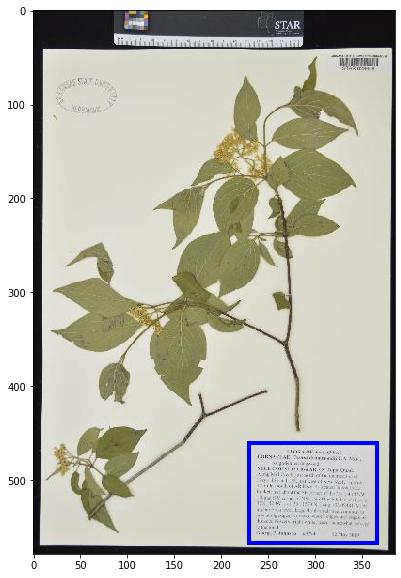

In [15]:
def show_image(idx):
    subject = valid.iloc[idx]

    image = Image.open(subject[PATH])

    draw = ImageDraw.Draw(image)

    draw = ImageDraw.Draw(image)
    draw.rectangle(subject[BOX], width=4, outline='#0000ff')

    plt.figure(figsize=(10, 10))
    plt.imshow(image)


# interact(show_image, idx=(0, valid.shape[0] - 1))
show_image(0)